<a href="https://colab.research.google.com/github/aashu-0/llm-from-scratch/blob/main/llm_book_notes/lora_instruction_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Loading and Preparation

In [ ]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/gururise/AlpacaDataCleaned/refs/heads/main/alpaca_data_cleaned.json"

file_path = 'alpaca_data.json'
urllib.request.urlretrieve(url, file_path)

# load`
with open(file_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

print(f'Number of entries: {len(dataset)}')

Number of entries: 51760


In [ ]:
# a subset of the dataset -> 10k samples

import random
subset_size = 10000
random.seed(42)
subset_data = random.sample(dataset, subset_size) # a list of dictionaries

# save
subset_file_path = 'alpaca_subset.json'

# to convert list to json-formatted string
with open(subset_file_path, 'w', encoding='utf-8') as f:
    json.dump(subset_data, f, indent=4)

print(f'Number of entries: {len(subset_data)}')

Number of entries: 10000


In [ ]:
def format_input(entry):
  instruction_txt = (
      f"Below is an instruction that describes a task. "
      f"Write a response that appropriately completes the request.\n\n"
      f"### Instruction:\n{entry['instruction']}"
  )
  input_text = (
      f"\n\n### Input:\n{entry['input']}" if entry['input'] else ''
  )
  return instruction_txt + input_text

In [ ]:
model_input = format_input(subset_data[1000])
desired_response = f"\n\n### Response:\n{subset_data[1000]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Edit the following sentence to make it more concise and powerful: "My painting skills are not very good".

### Response:
"I need to improve my painting skills."


In [ ]:
train_set = int(len(subset_data)*0.85)
test_set = int(len(subset_data)*0.1)
val_set = len(subset_data) - train_set - test_set

train_data = subset_data[:train_set]
test_data = subset_data[train_set:train_set+test_set]
val_data = subset_data[train_set+test_set:]

print(f'Train set size: {len(train_data)}')
print(f'Test set size: {len(test_data)}')
print(f'Validation set size: {len(val_data)}')

Train set size: 8500
Test set size: 1000
Validation set size: 500


In [ ]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data
    self.encode_texts = []
    for entry in data:
      input_with_instruction = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = input_with_instruction + response_text
      self.encode_texts.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self, index):
     return self.encode_texts[index]

  def __len__(self):
    return len(self.data)

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id= 50256,
    allowed_max_length=None,
    ignore_index=-100,
    device = 'cpu'):

  batch_max_length = max(len(item) for item in batch)
  inputs_lst, targets_lst = [], []
  for item in batch:
    new_item = item.copy()
    new_item += [pad_token_id]

    padded = (new_item + [pad_token_id]* (batch_max_length - len(item)))
    inputs= torch.tensor(padded[:-1])
    targets= torch.tensor(padded[1:])

    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze() # returns the indices of True values
    if indices.numel() >1:
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# fix or pre-fill some argument in custom_collate_function
from functools import partial
custom_collate_fn = partial(
    custom_collate_fn,
    allowed_max_length=512,
    device=device
)

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00


In [ ]:
# tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [ ]:
# dataloader
from torch.utils.data import DataLoader

num_workers = 0
batch_size =2

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=True,
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=num_workers,
    drop_last=False,
)

In [ ]:
for i, (inputs, targets) in enumerate(train_loader):
  print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
  if i==10:
    break

Inputs: torch.Size([2, 361]), Targets: torch.Size([2, 361])
Inputs: torch.Size([2, 81]), Targets: torch.Size([2, 81])
Inputs: torch.Size([2, 308]), Targets: torch.Size([2, 308])
Inputs: torch.Size([2, 65]), Targets: torch.Size([2, 65])
Inputs: torch.Size([2, 232]), Targets: torch.Size([2, 232])
Inputs: torch.Size([2, 167]), Targets: torch.Size([2, 167])
Inputs: torch.Size([2, 64]), Targets: torch.Size([2, 64])
Inputs: torch.Size([2, 228]), Targets: torch.Size([2, 228])
Inputs: torch.Size([2, 285]), Targets: torch.Size([2, 285])
Inputs: torch.Size([2, 347]), Targets: torch.Size([2, 347])
Inputs: torch.Size([2, 424]), Targets: torch.Size([2, 424])


In [ ]:
# getting scripts from github
!git clone https://github.com/aashu-0/llm-from-scratch.git
%cd llm-from-scratch/llm_book_notes

Cloning into 'llm-from-scratch'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 160 (delta 92), reused 88 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (160/160), 234.06 KiB | 6.16 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/llm-from-scratch/llm_book_notes


In [ ]:
import sys
sys.path.append('/content/llm-from-scratch/llm_book_notes')

In [ ]:
# get gpt_download.py from @rasbt github
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
urllib.request.urlretrieve(url, "gpt_download.py")

('gpt_download.py', <http.client.HTTPMessage at 0x797480af5cd0>)

In [ ]:
from load_weights import load_weights_into_gpt
from GPT import GPTModel
from gpt_download import download_and_load_gpt2

BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.2,
    'qkv_bias': True
}

model_configs = {
    'gpt2 (124M)': {'emb_dim': 768 , 'n_layers': 12, 'n_heads': 12},
    'gpt2-medium (355M)': {'emb_dim':1024 , 'n_layers':24, 'n_heads':16},
    'gpt2-large (774M)': {'emb_dim': 1280 , 'n_layers': 36, 'n_heads':20},
    'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers':48, 'n_heads': 25}
}

CHOOSE_MODEL = 'gpt2-medium (355M)'
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(' ')[-1].lstrip('(').rstrip(')')

settings, params = download_and_load_gpt2(
    model_size = model_size,
    models_dir = 'gpt2'
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 97.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.95MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 101kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [02:17<00:00, 10.3MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 10.9MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.03MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.50MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear

#### Implementing a LORA Layer

`rank` -> inner dimension of matrices A and B

`alpha` -> scaling factor

In [ ]:
import math
import torch.nn as nn

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
      super().__init__()
      self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
      torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
      self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
      self.alpha = alpha

    def forward(self, x):
      x = self.alpha * (x @ self.A @ self.B)
      return x

In [ ]:
# replacing linear layers with linearwithlora layer
class LinearWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(
        linear.in_features, linear.out_features, rank, alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)

In [ ]:
# replace linear with linearwithlora layer

def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      setattr(
          model,
          name,
          LinearWithLoRA(module, rank, alpha)
      )
    else:
      replace_linear_with_lora(module, rank, alpha)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {total_params}')

Total number of trainable parameters: 406286336


In [ ]:
# frezzing the original parameters
for param in model.parameters():
  param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Now, Total number of trainable parameters: {total_params}')

Now, Total number of trainable parameters: 0


In [ ]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of LORA trainable parameters: {total_params}')

Total number of LORA trainable parameters: 7898384


In [ ]:
# 406286336 / 7898384

In [ ]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.2, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=102

In [ ]:
# assess our raw model(no fine tuning)
torch.manual_seed(123)
input_text = format_input(val_data[5])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Estimate the cost of living for a student staying in Oxford for one year.


In [ ]:
from utilities import text_to_token_ids, token_ids_to_text
from GPT import generate

token_ids = generate(
    model = model,
    idx = text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens =35,
    context_size= BASE_CONFIG['context_length'],
    eos_id= 50256
)
generated_text =token_ids_to_text(token_ids, tokenizer)
generated_text

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nEstimate the cost of living for a student staying in Oxford for one year.\n\n### Response:\n\nEstimate the cost of living for a student staying in Oxford for one year.\n\n### Instruction:\n\nEstimate the cost of'

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

Estimate the cost of living for a student staying in Oxford for one year.

### Instruction:

Estimate the cost of


In [ ]:
from utilities import train_model_grad_accum, calc_loss_loader

In [ ]:
# initial loss for the train and val dataset
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print(f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')

Train loss: 2.7992, Val loss: 2.8641


In [ ]:
# training code
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.00005,
                              weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_grad_accum(
    model=model,
    train_dataloader= train_loader,
    val_dataloader= val_loader,
    optimizer= optimizer,
    device=device,
    num_epochs= num_epochs,
    eval_freq= 5,
    eval_iter= 5,
    start_context= format_input(val_data[0]),
    tokenizer= tokenizer,
    grad_accum_steps= 4
    )

end_time = time.time()

time_in_mins = (end_time - start_time)/60
print(f'Time taken to train: {time_in_mins:.2f} minutes')

Epoch: 1 | Step: 000000
Train Loss: 2.794 | Val Loss: 2.430
Epoch: 1 | Step: 000005
Train Loss: 1.759 | Val Loss: 2.032
Epoch: 1 | Step: 000010
Train Loss: 1.957 | Val Loss: 1.879
Epoch: 1 | Step: 000015
Train Loss: 1.935 | Val Loss: 1.795
Epoch: 1 | Step: 000020
Train Loss: 1.763 | Val Loss: 1.762
Epoch: 1 | Step: 000025
Train Loss: 1.559 | Val Loss: 1.741
Epoch: 1 | Step: 000030
Train Loss: 1.615 | Val Loss: 1.721
Epoch: 1 | Step: 000035
Train Loss: 1.683 | Val Loss: 1.710
Epoch: 1 | Step: 000040
Train Loss: 1.851 | Val Loss: 1.707
Epoch: 1 | Step: 000045
Train Loss: 1.797 | Val Loss: 1.704
Epoch: 1 | Step: 000050
Train Loss: 1.506 | Val Loss: 1.699
Epoch: 1 | Step: 000055
Train Loss: 1.611 | Val Loss: 1.691
Epoch: 1 | Step: 000060
Train Loss: 1.667 | Val Loss: 1.674
Epoch: 1 | Step: 000065
Train Loss: 1.464 | Val Loss: 1.680
Epoch: 1 | Step: 000070
Train Loss: 1.765 | Val Loss: 1.669
Epoch: 1 | Step: 000075
Train Loss: 1.689 | Val Loss: 1.665
Epoch: 1 | Step: 000080
Train Loss: 1.49

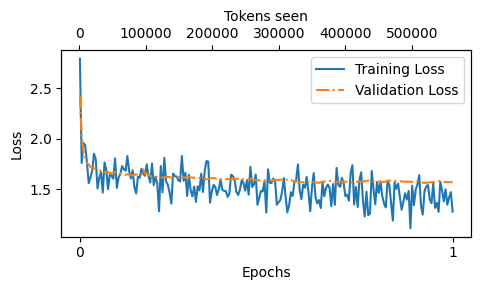

In [ ]:
from utilities import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)